# Obect detection using PyTorch - Training
- We will use pretrained FasterRCNN from torchvision
- Use of Albumentations
- Calculate Validation IOU
- Early Stopping
- Ensemble boxes using weighted box fusion
- Generate and view results on public test data set

This is a PyTorch implementation of FasterRCNN using Resnet50 backbone. We will also leverage the pretrained model available in PyTorch.

Additional reading: https://arxiv.org/abs/1506.01497


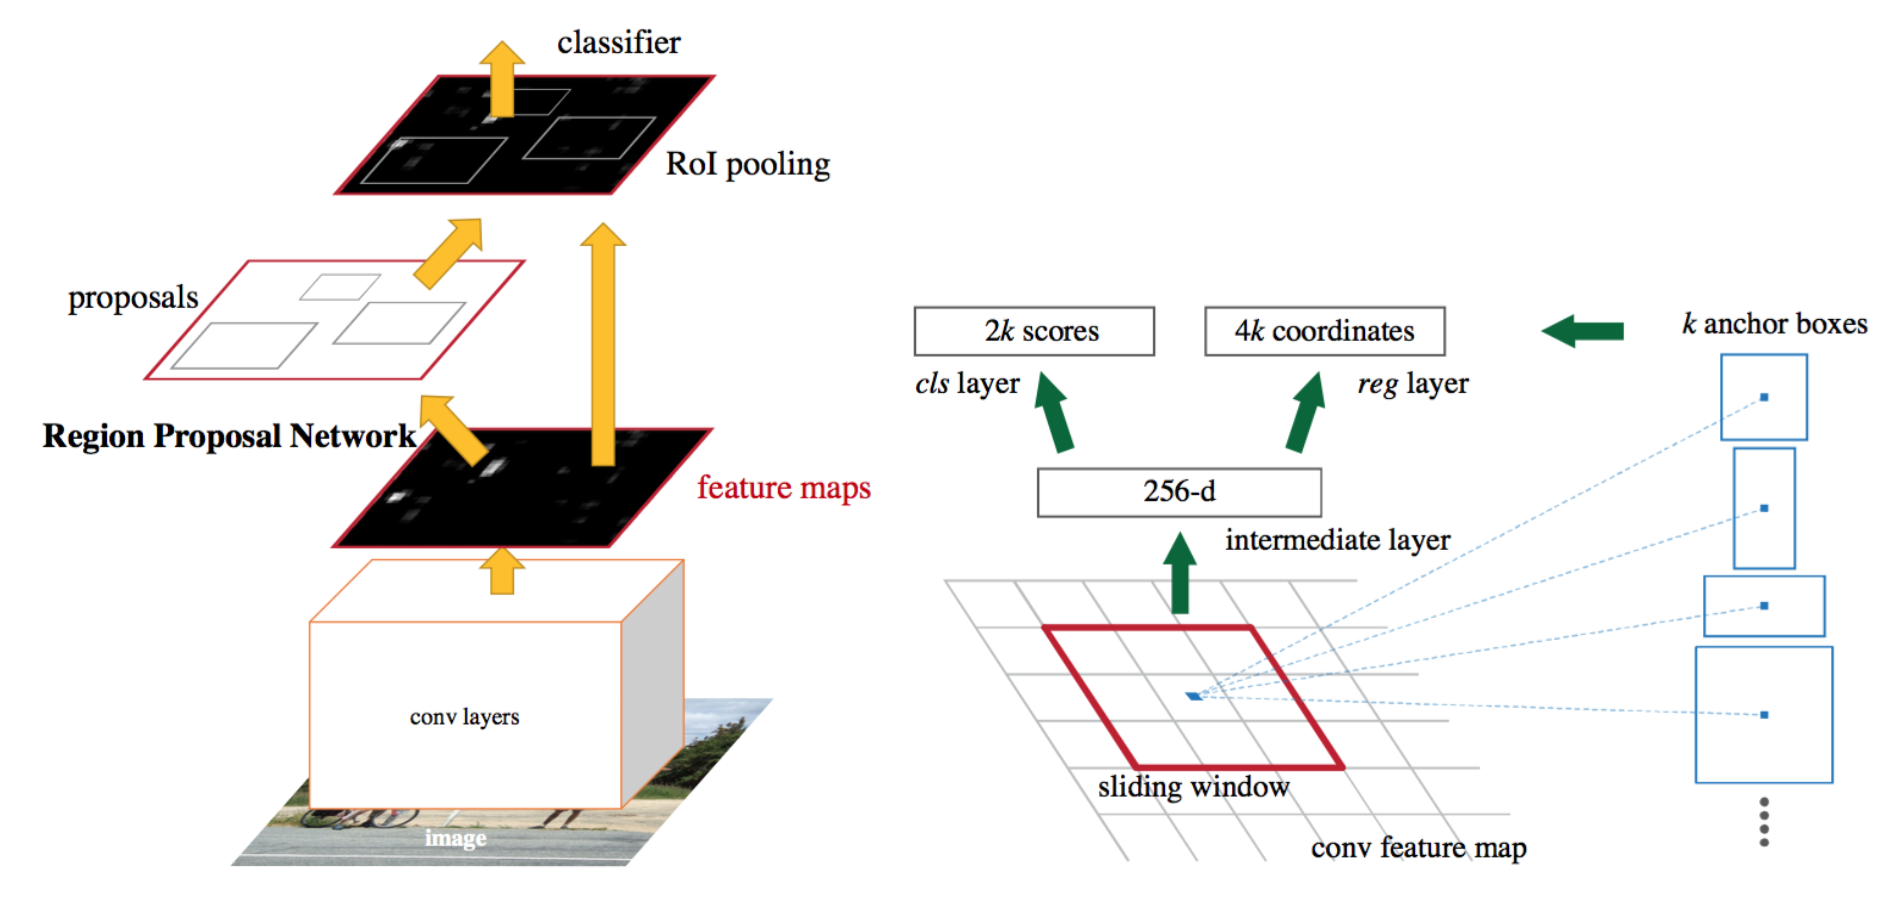

Please Uncomment the below block if you are executing this notebook in Google Colab.
You will have to include kaggle.json to download the dataset. Instructions here for downloading kaggle.json - https://www.kaggle.com/docs/api#getting-started-installation-&-authentication

In [1]:
# To import kaggle datasets
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6


# import kaggle json to connect to kaggle user account to download datsets
#files.upload()

# see if kaggle json exists
!ls -lha kaggle.json

# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# download our dataset
!kaggle competitions download -c global-wheat-detection --force # Download Global Wheat Detection dataset from Kaggle
!mkdir global-wheat-detection
!unzip global-wheat-detection.zip -d global-wheat-detection

!pip install albumentations==0.4.6

'!pip uninstall -y kaggle\n!pip install --upgrade pip\n!pip install kaggle==1.5.6\n\n\n# import kaggle json to connect to kaggle user account to download datsets\n#files.upload()\n\n# see if kaggle json exists\n!ls -lha kaggle.json\n\n# The Kaggle API client expects this file to be in ~/.kaggle,\n# so lets move it there.\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n\n# This permissions change avoids a warning on Kaggle tool startup.\n!chmod 600 ~/.kaggle/kaggle.json\n\n# download our dataset\n!kaggle competitions download -c global-wheat-detection --force # Download Global Wheat Detection dataset from Kaggle\n!mkdir global-wheat-detection\n!unzip global-wheat-detection.zip -d global-wheat-detection\n\n!pip install albumentations==0.4.6'

# Install required packages

In [2]:
!pip install ensemble-boxes

# Import libraries

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
import datetime
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt


import numba
import cv2
import ast
from glob import glob

from numba import jit
from typing import List, Union, Tuple

# Inputs required for training

In [4]:
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
model_path ='/kaggle/input/global-wheat-detection-pretrained-weights/fasterrcnn_resnet50_fpn2_17July.pth'#'fasterrcnn_resnet50_fpn2.pth' # Path for the best model to be saved
es_patience = 2 #This is required for early stopping, the number of epochs we will wait with no improvement before stopping

# Reading box coordinates from train.csv

In [5]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [6]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

# Creating Training and Validation datasets
We can further improve on this by using GroupKFold or StratifiedKFold 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [7]:
image_ids = train_df['image_id'].unique() #collecting all unique images
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [8]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]  
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [9]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [10]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id] #Getting all coordinates for the given image

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area,dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

# Albumentations
We are using very basic one for now i.e. Flip. We can increase on these as per our experiments.

This is a very good notebook demonstrating various PyTorch transformations -
https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=8q8a2Ha9pnaz

More on transforms - https://pytorch.org/docs/stable/torchvision/transforms.html


In [11]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Model - Transfer learning

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

**Here we will construct a Faster R-CNN model with a ResNet-50-FPN backbone, luckily we have the pretrained version available in PyTorch.**

More explanation and implementation details here - https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [12]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# Modifying model for our task
We now have to modify the loaded model for the task at hand, in most of the cases it would be the number of output classes.
In some cases it would be the last FC layer for the task at hand.

In [13]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Helper functions for training

In [14]:
#Function to calculate loss for every epoch
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


# Dataloader
In a lot of cases like this we cannot hold the training data in the memory and hence we make use of dataloders so that the required training data can be held in the memory on the fly during training

https://pytorch.org/docs/stable/data.html

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# IOU Calculation
The metric measured for this competion is IOU which is readily not availables in any packages for us to use and hence I have reused code and logic from this notebook - https://www.kaggle.com/pestipeti/competition-metric-details-script

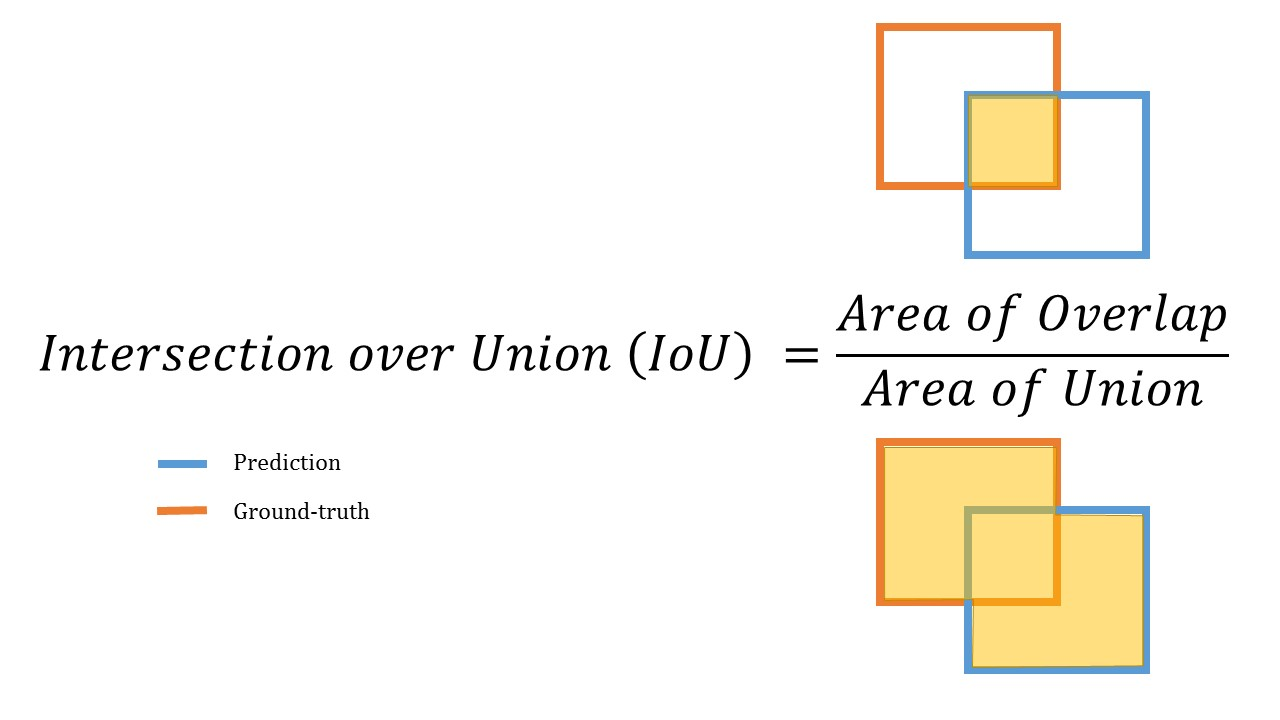

In [16]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


In [17]:
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

# WBF approach for ensemble
We will used weighted box fusion to collate multiple boxes - https://arxiv.org/pdf/1910.13302.pdf

In our case we only have one model, but we can save different models for each folds and then get the result from each model and then apply WBF to ensemble.

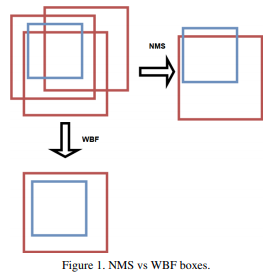

In [30]:
models = [model]
from ensemble_boxes import *

#device = torch.device('cuda:0')

def make_ensemble_predictions(images):
    images = list(image.to(device) for image in images)    
    result = []
    for net in models:
        net.eval()
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.55, skip_box_thr=0.5, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

# Training
We are using SGD optimizer here without scheduler.

We are using EarlyStopping. I implement this almost everywhere as it is very easy to implement i.e. hold a copy of weights when validation IOU (or accuracy or f1) increases and at the end of the training use the best weights. A easy powerful way to prevent overfitting.

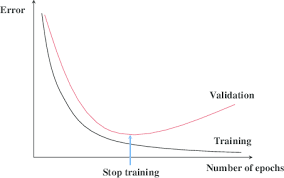

We can make this training more efficient by using Adam optimizer with a smaller learning rate and using ReduceLROnPlateau scheduler.

https://pytorch.org/docs/stable/optim.html#torch.optim.Adam

https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

In [20]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 10

In [ ]:
loss_hist = Averager()
best_val = None
patience = es_patience
for epoch in range(num_epochs):
    start_time = time.time()
    itr = 1
    loss_hist.reset()
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]#[{k: v.double().to(device) if k =='boxes' else v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    
    #At every epoch we will also calculate the validation IOU
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    model.eval()
    for images, targets,imageids in valid_data_loader: #return image, target, image_id
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]
        #outputs = model(images) 
        
        predictions = make_ensemble_predictions(images)
   
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.astype(np.int32).clip(min=0, max=1023)
            
            preds = boxes#outputs[i]['boxes'].data.cpu().numpy()
            #scores = outputs[i]['scores'].data.cpu().numpy()
            preds_sorted_idx = np.argsort(scores)[::-1]
            preds_sorted = preds[preds_sorted_idx]
            gt_boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            image_precision = calculate_image_precision(preds_sorted,
                                                    gt_boxes,
                                                    thresholds=iou_thresholds,
                                                    form='coco')

            validation_image_precisions.append(image_precision)
    val_iou = np.mean(validation_image_precisions)
    print(f"Epoch #{epoch+1} loss: {loss_hist.value}","Validation IOU: {0:.4f}".format(val_iou),"Time taken :",str(datetime.timedelta(seconds=time.time() - start_time))[:7])
    if not best_val:
        best_val = val_iou  # So any validation roc_auc we have is the best one for now
        print("Saving model")
        torch.save(model, model_path)  # Saving the model
        #continue
    if val_iou >= best_val:
        print("Saving model as IOU is increased from",best_val,"to",val_iou)
        best_val = val_iou
        patience = es_patience  # Resetting patience since we have new best validation accuracy
        torch.save(model, model_path)  # Saving current best model torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping. Best Validation IOU: {:.3f}'.format(best_val))
            break

# Loading best model

In [21]:
model = torch.load(model_path)

# Viewing results on public test data

In [22]:
test_df = pd.DataFrame()
test_df['image_id']=np.array([path.split('/')[-1][:-4] for path in glob(f'{DIR_TEST}/*.jpg')])

In [23]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

# Test transform and dataloader

In [24]:
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [28]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

## Generate Test predictions
We will generate predictions of test images and will also store the value to plot the detected objects

In [31]:
detection_threshold = 0.5
results = []
outputs = []
test_images = []
for images, image_ids in test_data_loader:
    images = list(image.to(device) for image in images)
    predictions = make_ensemble_predictions(images)

    for i, image in enumerate(images):
        test_images.append(image) #Saving image values
        boxes, scores, labels = run_wbf(predictions, image_index=i)

        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
            
        preds = boxes
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = preds[preds_sorted_idx]
        boxes = preds
        
        output = {
            'boxes': boxes,
            'scores': scores
        }

        outputs.append(output) #Saving outputs and scores
        image_id = image_ids[i]


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in b

## Visualizing test results

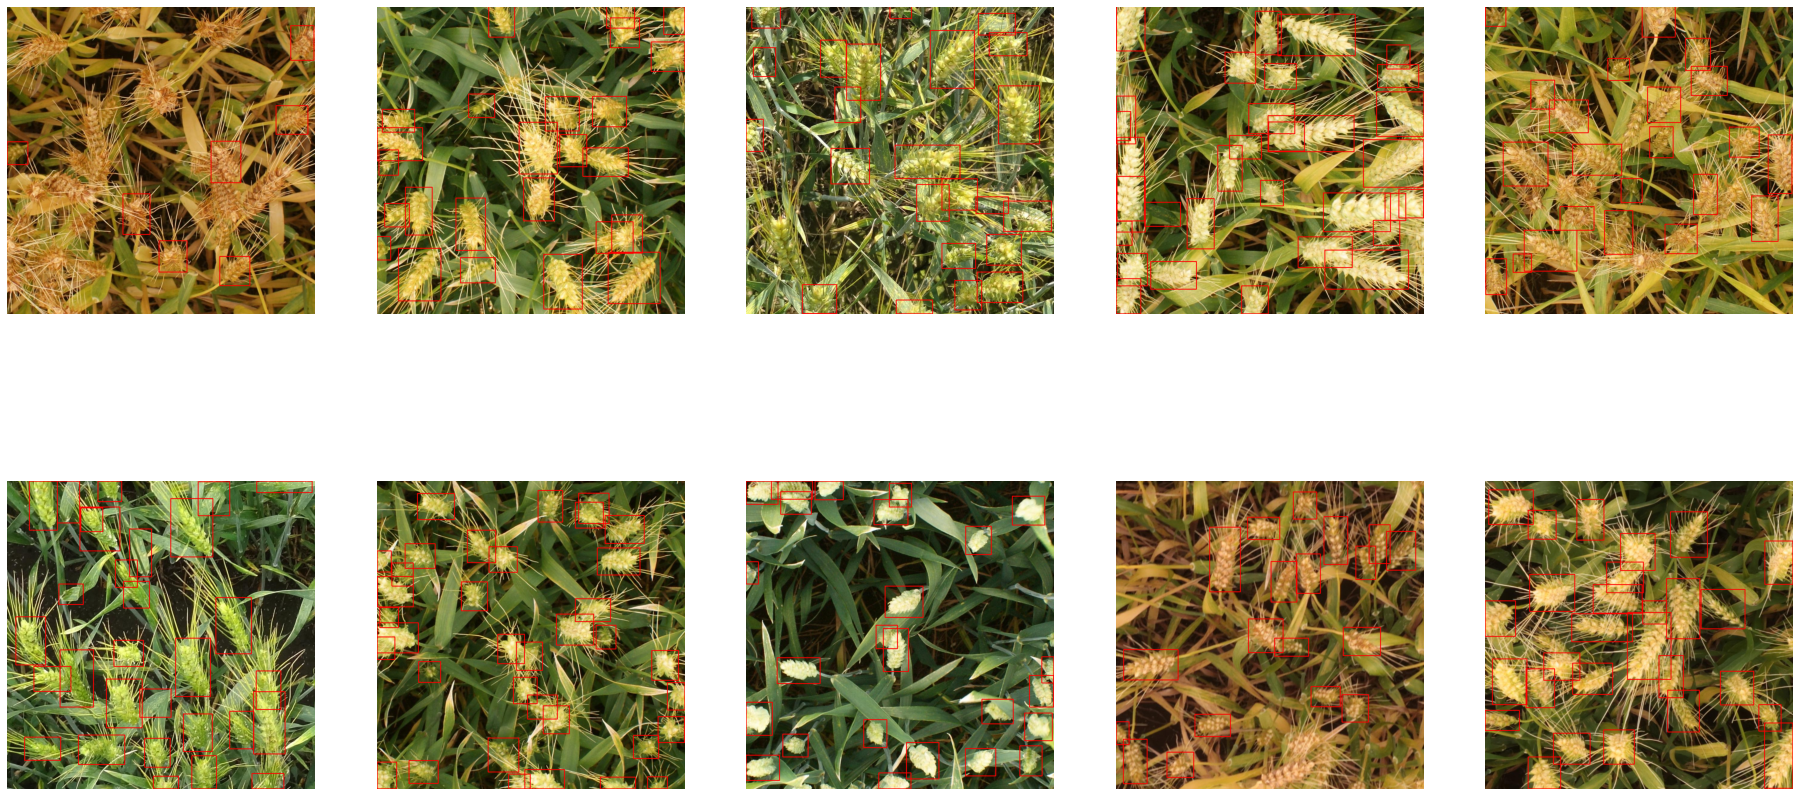

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(32, 16))
axs = axs.ravel()
for i in range(10):
    sample = test_images[i].permute(1,2,0).cpu().numpy()
    boxes = outputs[i]['boxes']
    scores = outputs[i]['scores']
    boxes = boxes[scores >= detection_threshold].astype(np.int32)

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    axs[i].set_axis_off()
    axs[i].imshow(sample)

The results look really good.

# Improvements to be done
Some easy improvements that can be done are:
1. Use Adam Optimizer.
2. Use ReducePlatueonLR schedueler.
3. Perform more image transformation.
4. Use StrathifiedKFold and save best model for each fold and then ensemble results from each model.